In [33]:
%pylab inline

import pandas as pd
import numpy as np
#import seaborn as sns
import scipy

import sys    
#reload(sys)  
#sys.setdefaultencoding('utf8')

from __future__ import division

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from pandas.plotting import autocorrelation_plot

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import numpy as np
import lstm, time

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


Populating the interactive namespace from numpy and matplotlib


In [24]:
df = pd.read_csv('coindesk-bitcoin.csv')
df.shape

(2718, 2)

In [8]:
df.tail(10)

,Date,Close Price
2708,2017-12-16 00:00:00,19343.04
2709,2017-12-17 00:00:00,19086.64
2710,2017-12-18 00:00:00,18960.52
2711,2017-12-19 00:00:00,17608.35
2712,2017-12-20 00:00:00,16454.72
2713,2017-12-21 00:00:00,15561.05
2714,2017-12-22 00:00:00,13857.14
2715,2017-12-23 22:15:00,15439.46
2716,This data was produced from the CoinDesk price...,NaN
2717,http://www.coindesk.com/price/,NaN


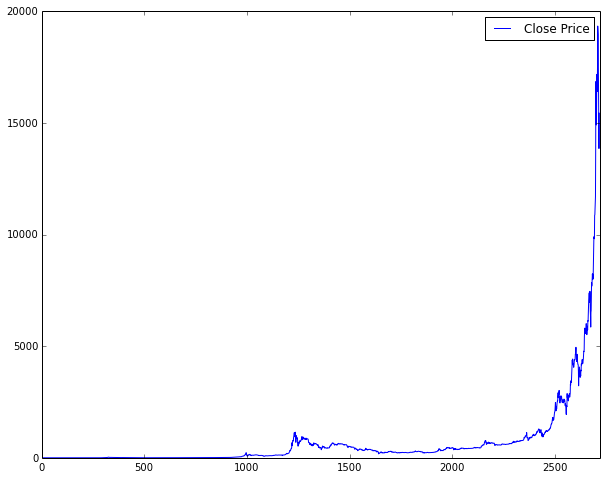

In [34]:
df.plot()

In [35]:
data = df.dropna().iloc[:,-1].tolist()

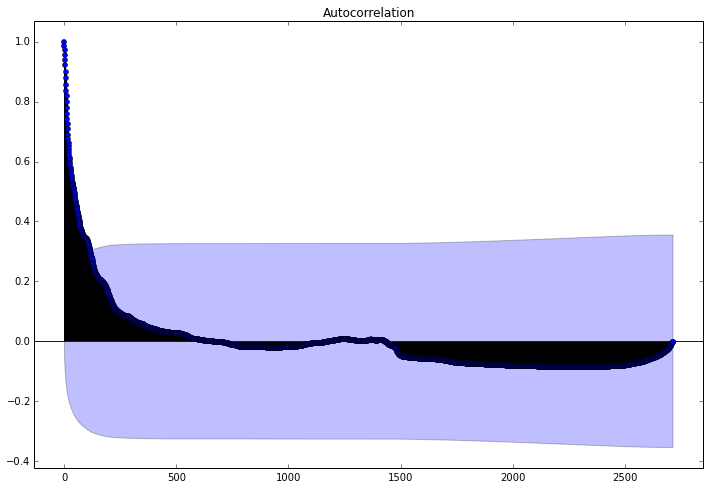

In [36]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(data, ax=ax1)

The Auto Correlation shows significant peaks. This indicates Moving Average (MA) process. Identification of an MA model is often best done with the ACF.

Also, the series seem to follow a trend, since it is moving upward in a parabolic-like trend. A second difference might be useful to account for a parabolic trend in the data.

Based on the above analysis we make a guess that the model is ARIMA(p,d,q) where: p=1 is autoregressive term. q=1 is the moving average term. d=2 is the second order differencing term. We test this hypothesis to see if it provides a good fit.

90 points of significant moving average, 90-day moving average prediction

In [54]:
arima_111 = sm.tsa.ARIMA(data, (1,2,1)).fit()
arima_111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                 2714
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -16912.709
Method:                       css-mle   S.D. of innovations            122.983
Date:                Mon, 25 Dec 2017   AIC                          33833.419
Time:                        19:57:20   BIC                          33857.044
Sample:                             2   HQIC                         33841.960
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0326      0.027      1.199      0.231      -0.021       0.086
ar.L1.D2.y     0.2250      0.019     11.551      0.000       0.187       0.263
ma.L1.D2.y    -0.9917      0.003   -342.088      0.000      -0.997      -0.986
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.4453           +0.0000j            4.4453            0.0000
MA.1            1.0084           +0.0000j            1.0084            0.0000
-----------------------------------------------------------------------------
"""

based on p-values for the 3 estimated parameters, 2nd and 3rd parameter seems to cause a good estimate.

### LSTM based prediction

In [37]:
def split_train_test(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [61]:
sd = 300
np.random.seed(sd)

seq_length_train = 50
1 = 30

X_train, y_train, X_test, y_test = split_train_test(data, 
                                                  seq_length_train,
                                                  True)

In [62]:
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print 'compilation time : ', time.time() - start

model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=1,
    validation_split=0.05)

predictions = lstm.predict_sequences_multiple(model, 
                                              X_test,
                                              seq_length_train, 
                                              seq_length_pred)

compilation time :  0.0360848903656
Train on 2279 samples, validate on 120 samples
Epoch 1/1
2279/2279 [==============================] - 6s - loss: 2.0010 - val_loss: 3.8080


yo


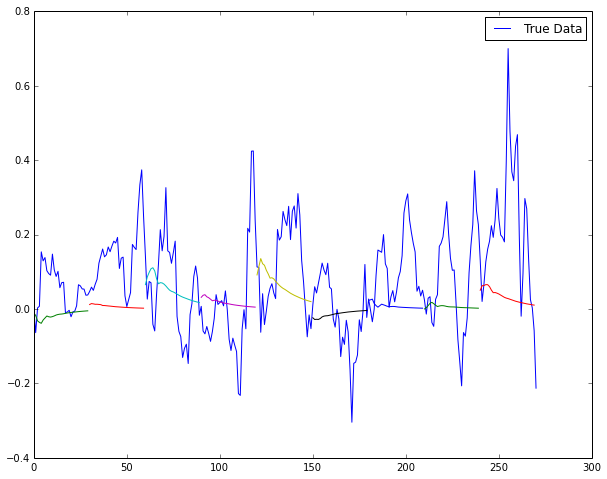

In [49]:
# random seed 123
lstm.plot_results_multiple(predictions, y_test, seq_length_pred)

Fails to produce anything meaningful if not normalized:

yo


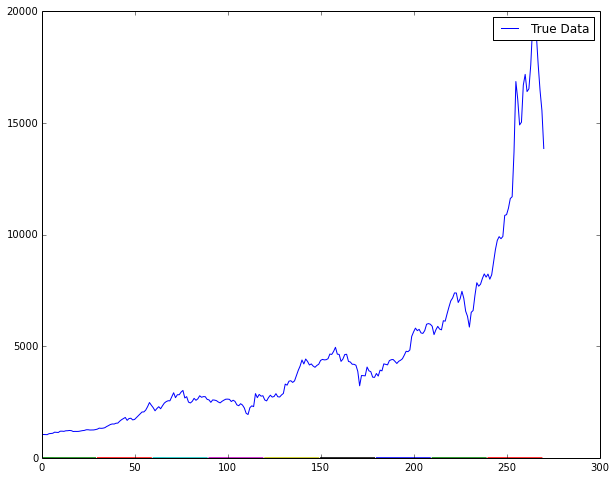

In [53]:
# no normalization
lstm.plot_results_multiple(predictions, y_test, seq_length_pred)

yo


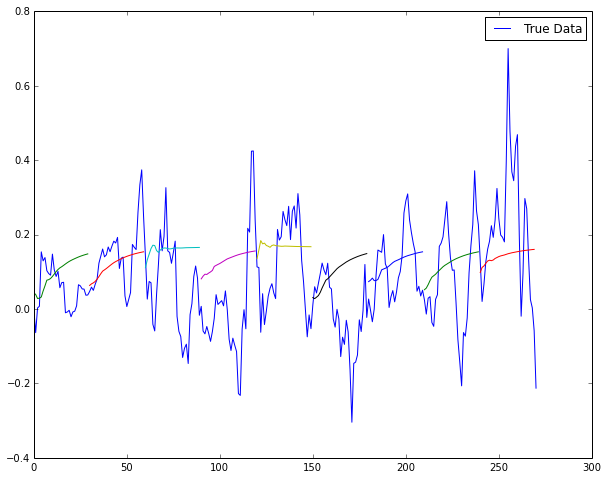

In [60]:
# Random seed 300
lstm.plot_results_multiple(predictions, y_test, seq_length_pred)

yo


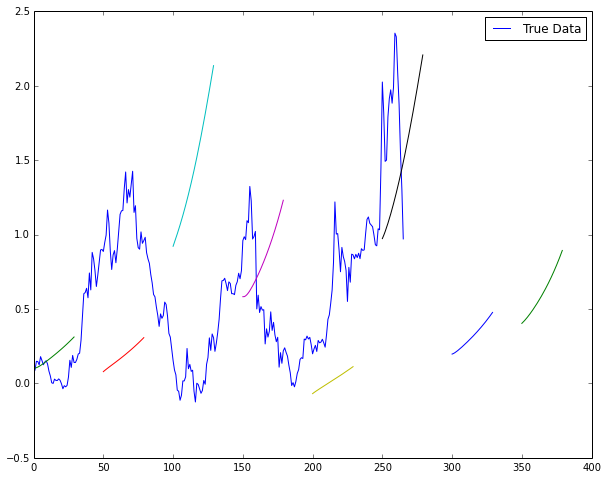

In [65]:
lstm.plot_results_multiple(predictions, y_test, 50)